In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos, exp
from numpy.linalg import inv
np.random.seed(3011)

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

In [38]:
#fixing parameter D_r, W, B, T
D_r = 500

def pickw(w=0.005, D_r = D_r, D = 3): #for different system remember to change D and run all cells again!!!
    W_in = np.random.uniform(-w, w, (D_r, D))
    return W_in

def pickb(b=4, D_r = D_r):
    B_in = np.random.uniform(-b, b, (D_r,1))
    return B_in

W = pickw(w=0.005)
B = pickb(b=4)

t0 = 0
t1 = 2*np.pi

In [39]:
#Algorithm
def find_approximation(system: callable, t0: float, t1: float,
                       N=100, D_r=D_r, w=W, b=B, beta=1E-5):
    U: np.ndarray = system(np.linspace(t0, t1, N+1))
    D = U.shape[0]
    U_o = U[:, 1:]
    U_i = U[:, :-1]
    W_in = w
    b_in = b
    Phi = np.tanh(W_in @ U_i + b_in)
    W_LR = (U_o @ Phi.T @ inv(Phi @ Phi.T + beta * np.identity(D_r)))

    U_hat = np.atleast_2d(U[:, 0]).T
    for _ in range(N):
        u_n = U_hat[:, -1]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_hat = np.concatenate((U_hat, u_np1), axis=1)
        
    U_pred = np.atleast_2d(U_hat[:, -1]).T
    for _ in range(N):
        u_n = U_pred[:, -1]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_pred = np.concatenate((U_pred, u_np1), axis=1)
    
    U_hat2 = np.atleast_2d(U[:, 0]).T
    for n in range(N):
        u_n = U[:, n]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_hat2 = np.concatenate((U_hat2, u_np1), axis=1)
    #return U, U_hat
    return U, U_hat, U_pred, U_hat2

In [4]:
def linear_system(t, c1=1, c2=1):

    """
    Return values for the system

    dx/dt = (0   1) (x)
    dy/dt   (-1  0) (y)
    """
    x = c1 * sin(t) - c2 * cos(t)
    y = c1 * cos(t) + c2 * sin(t)
    return np.array([x, y])

In [40]:
#Lorenz system
def get_lorenz_vals(dt):
    def lorenz1(xyz, t, s=10, r=28, b=8/3):
        x,y,z = xyz
        dx = s*(y - x)
        dy = r*x - y - x*z
        dz = x*y - b*z
        return np.array([dx,dy,dz])
    
    from scipy.integrate import odeint
    sol = odeint(lorenz1, [0,2,0], dt)
    xs,ys,zs = sol.T

    return sol.T

In [41]:
def find_norm2(system:callable, N_0, D_r0=D_r, w_0=W, b_0=B):
    U, U_hat, U_pred, U_hat2 = find_approximation(system, t0, t1, N=N_0, D_r=D_r0, w = w_0, b = b_0)
    norm1 = 0
    norm2 = 0
    for n in range(N_0):
        norm1 += (np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))**2
        norm2 += (np.linalg.norm(U[:,n]-U_hat2[:,n]) / np.linalg.norm(U[:,n]))**2
    return np.sqrt(norm1) / N_0, np.sqrt(norm2) / N_0

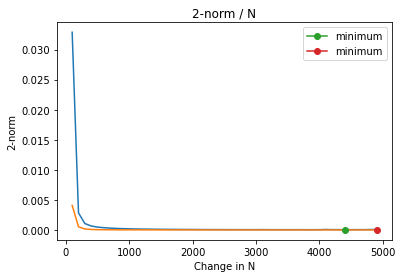

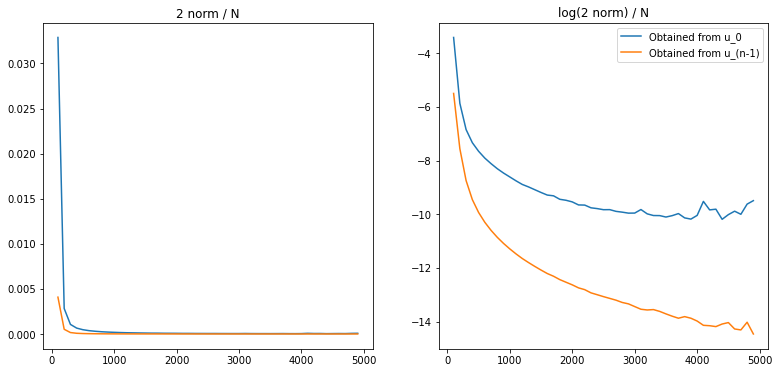

In [43]:
N = np.arange(100, 5000, 100)

norm1 = []
norm2 = []
for n in N:
    n1, n2 = find_norm2(get_lorenz_vals, n)
    norm1.append(n1)
    norm2.append(n2)
    
i1 = np.argmin(norm1)
i2 = np.argmin(norm2)

plt.plot(N, norm1)
plt.plot(N, norm2)
plt.plot(N[i1], norm1[i1], marker='o', label='minimum')
plt.plot(N[i2], norm2[i2], marker='o', label='minimum')
plt.legend()
plt.xlabel("Change in N")
plt.ylabel("2-norm")
plt.title("2-norm / N")


#plot for 2-norm of lorenz system!
figure, axis = plt.subplots(1, 2, figsize=(13,6))
axis[0].plot(N, norm1, label="Obtained from u_0")
axis[0].plot(N, norm2, label="Obtained from u_(n-1)")
axis[0].set_title("2 norm / N")
axis[1].plot(N, np.log(norm1), label="Obtained from u_0")
axis[1].plot(N, np.log(norm2), label="Obtained from u_(n-1)")
axis[1].set_title("log(2 norm) / N")
plt.legend()

In [13]:
def find_norminf(system:callable, N_0, D_r0=D_r, w_0=W, b_0=B):
    U, U_hat, U_pred, U_hat2 = find_approximation(system, t0, t1, N=N_0, D_r=D_r0, w = w_0, b = b_0)
    norm1 = []
    norm2 = []
    for n in range(N_0):
        norm1.append(np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))
        norm2.append(np.linalg.norm(U[:,n]-U_hat2[:,n]) / np.linalg.norm(U[:,n]))
    return max(norm1), max(norm2)

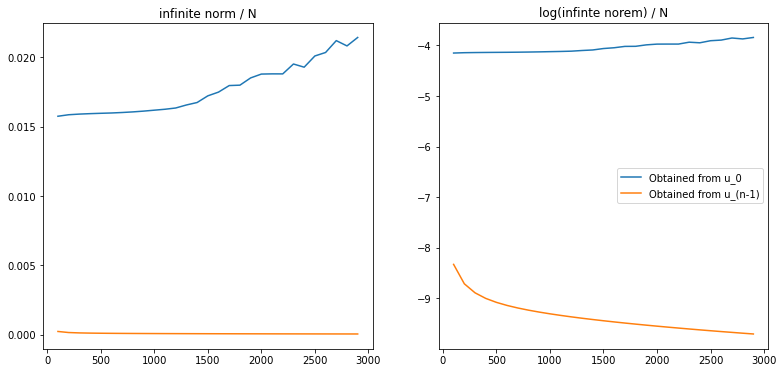

In [30]:
#plot for inf norm of linear system
N = np.arange(100, 3000, 100)

norminf3 = []
norminf4 = []
for n in N:
    norm3, norm4 = find_norminf(linear_system, n)
    norminf3.append(norm3)
    norminf4.append(norm4)

i3 = np.argmin(norminf3)
i4 = np.argmin(norminf4)

figure, axis = plt.subplots(1, 2, figsize=(13,6))
axis[0].plot(N, norminf3, label="Obtained from u_0")
axis[0].plot(N, norminf4, label="Obtained from u_(n-1)")
axis[0].set_title("infinite norm / N")
axis[1].plot(N, np.log(norminf3), label="Obtained from u_0")
axis[1].plot(N, np.log(norminf4), label="Obtained from u_(n-1)")
axis[1].set_title("log(infinte norem) / N")
plt.legend()